In [1]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import sys

sys.path.append("/code")

from tqdm import tqdm
import torch
import time
# device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# import gym
# import recogym

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

torch.backends.cudnn.benchmark = torch.cuda.is_available()
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")  # TF32 = big speedup on Ada


from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from scipy.special import softmax
import optuna
# from memory_profiler import profile

from plots_and_stats import compute_statistics_and_plots, plot_calibration_and_rank_table

from estimators import (
    DirectMethod as DM
)

from simulation_utils import (
    eval_policy,
    generate_dataset,
    create_simulation_data_from_pi,
    get_train_data,
    get_opl_results_dict,
    CustomCFDataset,
    calc_reward,
    get_weights_info
)

from models import (    
    LinearCFModel,
    NeighborhoodModel,
    BPRModel, 
    RegressionModel
)


from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial,
    random_policy_trainer_trial
)


random_state=12345
random_ = check_random_state(random_state)

pd.options.display.float_format = '{:,.8f}'.format

Using device: cuda
Using device: cuda
Using device: cuda


In [2]:
from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial,
    random_policy_trainer_trial
)

from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial,
    random_policy_trainer_trial
)

## Learning

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

Our parameters for the dataset will be
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$

to learn a new policy from $\pi$ we will sample from:
$$\pi_{start} = (1-\epsilon)*\pi + \epsilon * \pi_{random}$$

In [3]:
cols = [
    
    'dr_naive_mean', 'dr_naive_ci_low', 'dr_naive_ci_high', 'dr_naive_se',
    'dr_boot_mean', 'dr_boot_std', 'dr_boot_ci_low', 'dr_boot_ci_high',
    'ipw_boot_mean', 'ipw_boot_std', 'ipw_boot_ci_low', 'ipw_boot_ci_high',

    'cv_rmse_uniform', 'cv_signed_rmse_uniform', 'cv_bias_uniform',
    'cv_bias_lb_signed_uniform', 'cv_rmse_exp', 'cv_signed_rmse_exp',
    'cv_bias_exp', 'cv_bias_lb_signed_exp', 'loss_uniform', 'loss_exp',
    'score_naive_minus_cv_uniform', 'score_naive_minus_cv_exp'
    ]

In [4]:
'Spearman Kendall-Tau'.split()

['Spearman', 'Kendall-Tau']

In [5]:
cols = ['dr_naive_mean', 'dr_naive_ci_low',
         'dr_boot_mean', 'dr_boot_ci_low',
         'dr_uni_mean', 'dr_uni_ci_low',
         'ipw_boot_mean', 'ipw_boot_ci_low',
         'ipw_uni_mean', 'ipw_uni_ci_low']

In [6]:
# for num in [10000, 20000, 30000, 40000, 50000, 12345]:
#     df = pd.read_csv(f"trial_dfs/study_df_155_{num}.csv")

#     rank_tbl = plot_calibration_and_rank_table(
#         df,
#         cols=cols,
#         reward_col="user_attrs_actual_reward"
#     )

#     print(f"Num samples: {num}")
#     display(rank_tbl)

In [7]:
# df = pd.read_csv("trial_dfs/study_df_27_40000.csv")

# rank_tbl = plot_calibration_and_rank_table(
#     df,
#     cols=cols,
#     reward_col="user_attrs_actual_reward"
# )

# rank_tbl

In [8]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params)

Random Item CTR: 0.07066414727263938
Optimal greedy CTR: 0.09999926940951757
Second Best greedy CTR: 0.0980913477695915
Optimal Stochastic CTR: 0.09995326955796031
second Best Stochastic CTR: 0.08595012935428775
Our Initial CTR: 0.08610747363354625


In [ ]:
for n in np.arange(1, 20, 1):
    df, _ = random_policy_trainer_trial(
        train_size=1500 * n,
        dataset=train_dataset,
        n_policies=300,
        val_size=1000 * n,
    )
    df.to_csv(f"trial_dfs/random_trial_{n}_{300}.csv")

In [13]:
jaws, _ = random_policy_trainer_trial(
    train_size=5000,
    dataset=train_dataset,
    n_policies=300,
    val_size=2000,
    use_random=True,
    use_oracle=True,
    jaws=True,
)   

Simulation time for 7000 samples: 0.024325847625732422 seconds
[Regression] Baseline regression model fit time: 0.08s


Validation weights_info: {'gini': np.float64(0.4327335053092087), 'ess': np.float64(207.9715288808193), 'max_wi': np.float64(56.11305805954198), 'min_wi': np.float64(0.5546707394057788)}: 100%|██████████| 300/300 [01:06<00:00,  4.54it/s]    


In [24]:
rnd, _ = random_policy_trainer_trial(
    train_size=1500,
    dataset=train_dataset,
    n_policies=300,
    val_size=50000,
    use_random=True,
    use_oracle=False,
)   

Simulation time for 51500 samples: 0.35060906410217285 seconds
[Regression] Baseline regression model fit time: 0.01s


Validation weights_info: {'gini': np.float64(0.5658866651592954), 'ess': np.float64(6967.3085265019), 'max_wi': np.float64(148.6635256566331), 'min_wi': np.float64(0.2270144809835603)}: 100%|██████████| 300/300 [04:30<00:00,  1.11it/s]       


In [10]:
df_improve, _ = random_policy_trainer_trial(
    train_size=15000,
    dataset=train_dataset,
    n_policies=300,
    val_size=10000,
    use_random=False,
    use_oracle=True
)

df_random, _ = random_policy_trainer_trial(
    train_size=15000,
    dataset=train_dataset,
    n_policies=300,
    val_size=10000,
    use_random=True,
    use_oracle=False
)

df_learning_sim, _ = random_policy_trainer_trial(
    train_size=15000,
    dataset=train_dataset,
    n_policies=300,
    val_size=10000,
    use_random=True,
    use_oracle=True
)   

Validation weights_info: {'gini': np.float64(0.7596257585174588), 'ess': np.float64(328.4589537604993), 'max_wi': np.float64(271.84269873646076), 'min_wi': np.float64(0.18798347568806978)}: 100%|██████████| 300/300 [01:38<00:00,  3.05it/s]  


Simulation time for 25000 samples: 0.054917097091674805 seconds
[Regression] Baseline regression model fit time: 0.66s


Validation weights_info: {'gini': np.float64(0.5747288408731359), 'ess': np.float64(914.3165035467678), 'max_wi': np.float64(175.8320135644558), 'min_wi': np.float64(0.2253820137649005)}: 100%|██████████| 300/300 [01:43<00:00,  2.89it/s]    


Simulation time for 25000 samples: 0.04786968231201172 seconds
[Regression] Baseline regression model fit time: 0.56s


Validation weights_info: {'gini': np.float64(0.18091186179293872), 'ess': np.float64(6911.088343196813), 'max_wi': np.float64(22.064489140764177), 'min_wi': np.float64(0.7452383245596252)}: 100%|██████████| 300/300 [01:39<00:00,  3.03it/s]  


In [ ]:
df_improve = df_improve[0]
df_random = df_random[0]
df_learning_sim = df_learning_sim[0]

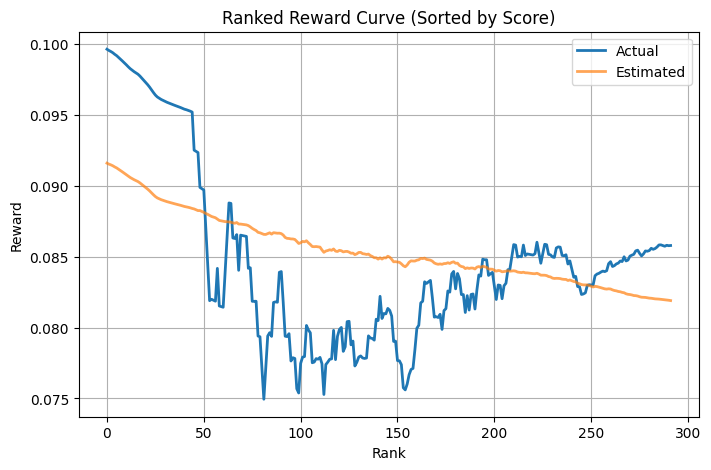

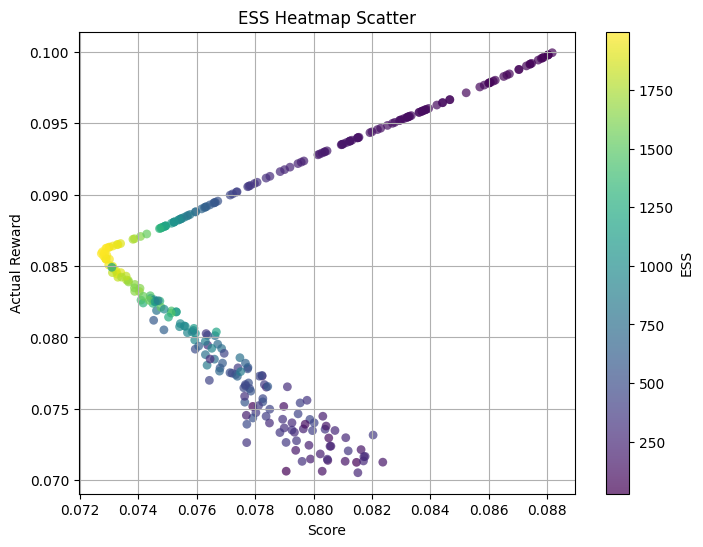

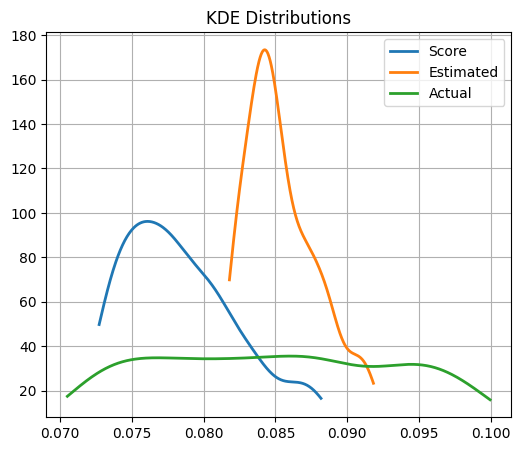

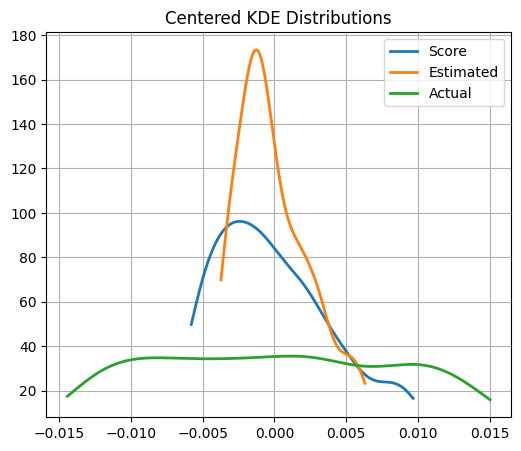

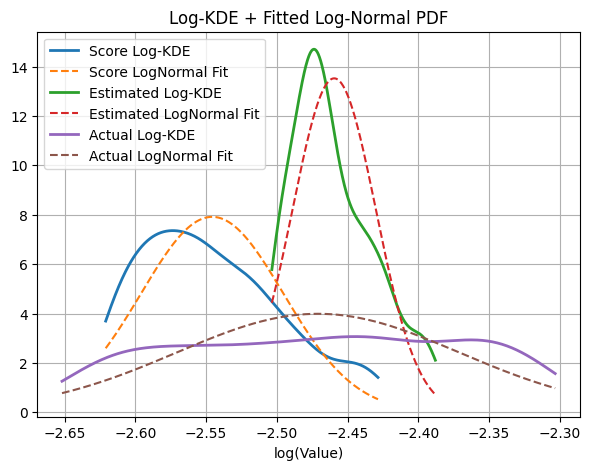

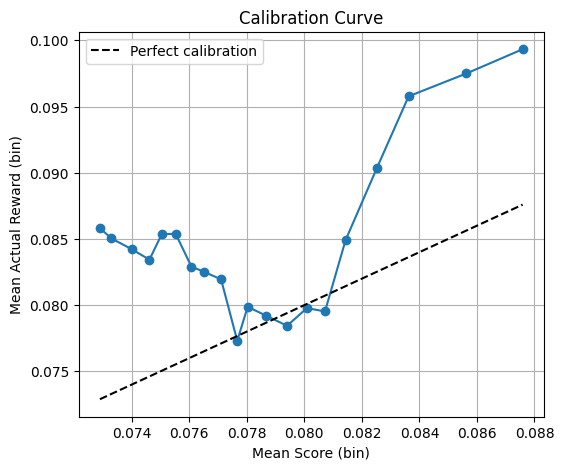

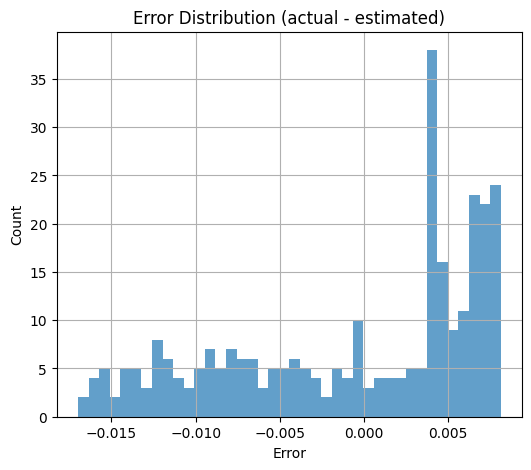

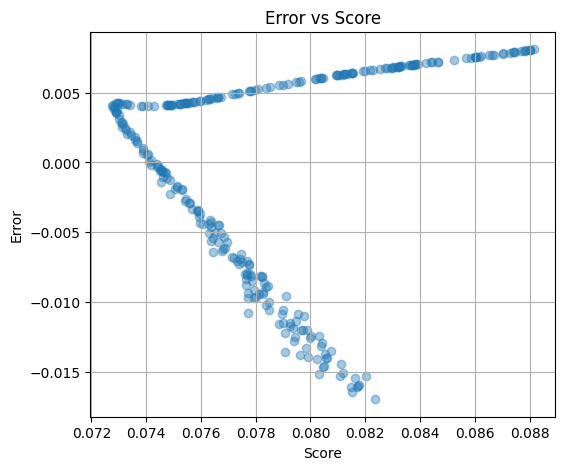

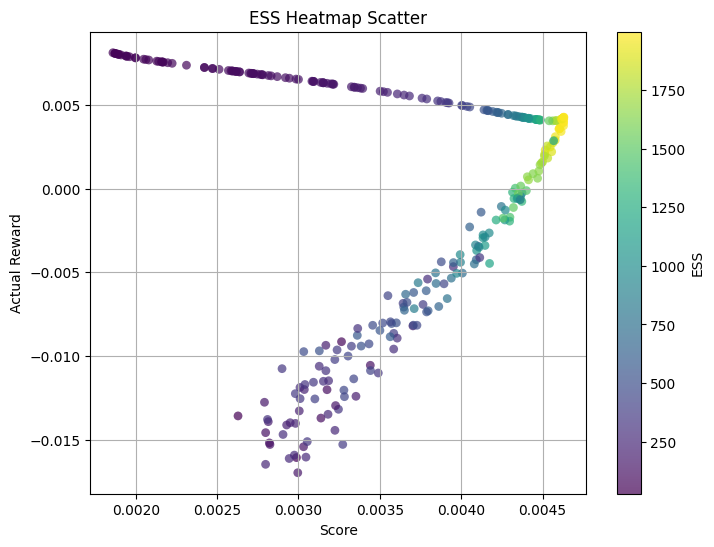

Correlation Metrics: {'pearson_score_actual': np.float64(0.44011604479460165), 'spearman_score_actual': np.float64(0.30511405682285353), 'spearman_est_actual': np.float64(0.3866785186502072)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9937785626191604), 'ndcg_est_actual': np.float64(0.9946191026369785)}
Error Metrics: {'mean_error': np.float64(-0.0005894505353589302), 'mae': np.float64(0.006502166890644627), 'rmse': np.float64(0.007483554196670006), 'std_error': np.float64(0.00746030371237407), 'max_error': np.float64(0.008116007902048542), 'min_error': np.float64(-0.016984223069783477)}


In [14]:
compute_statistics_and_plots(jaws)

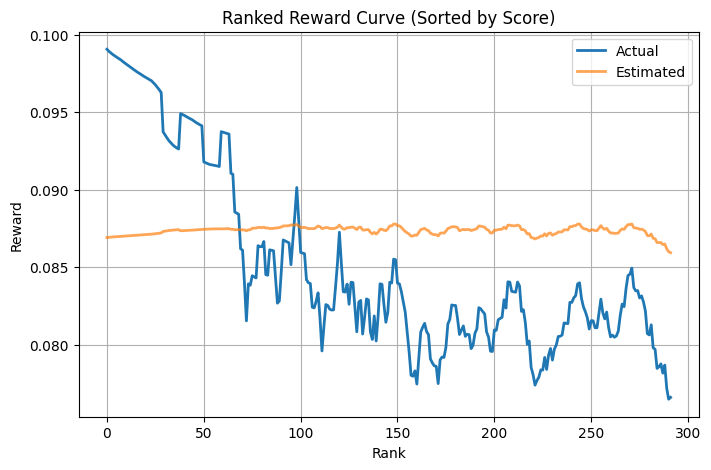

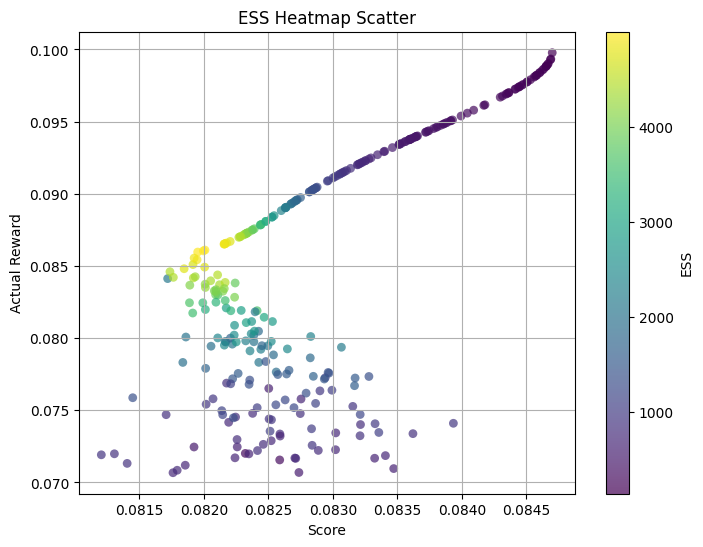

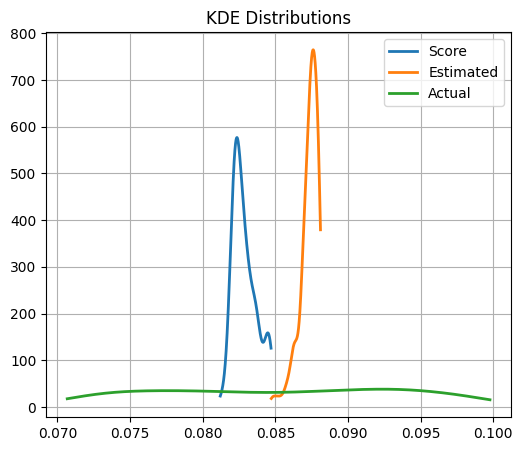

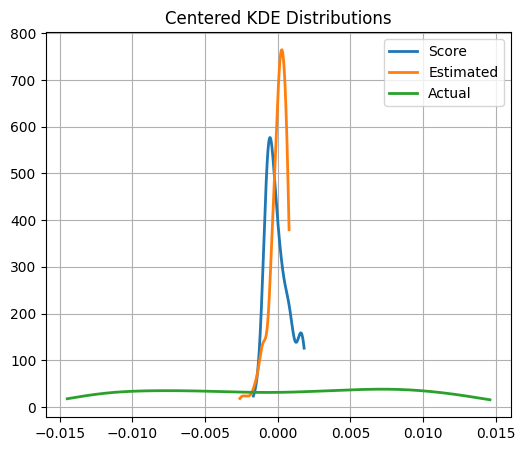

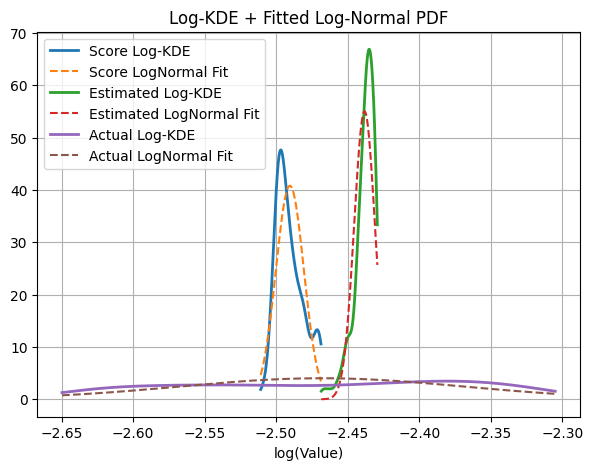

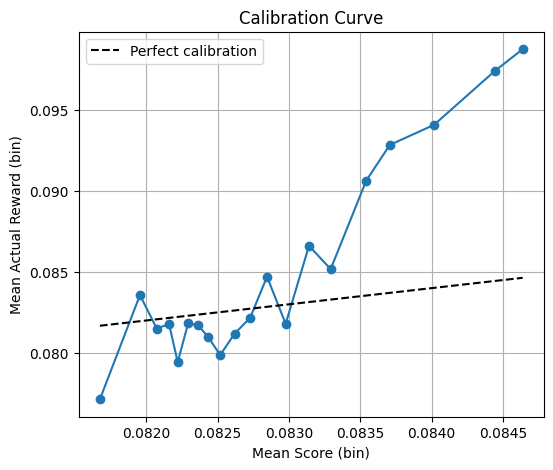

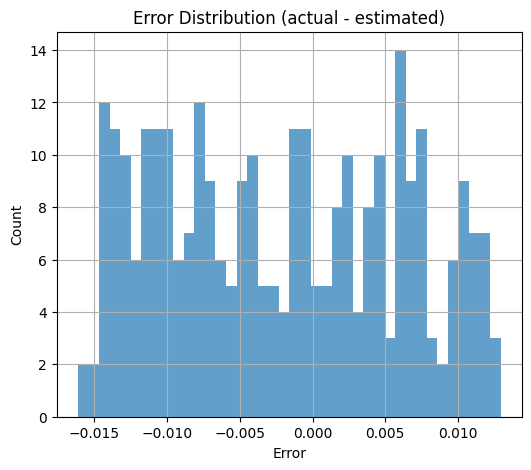

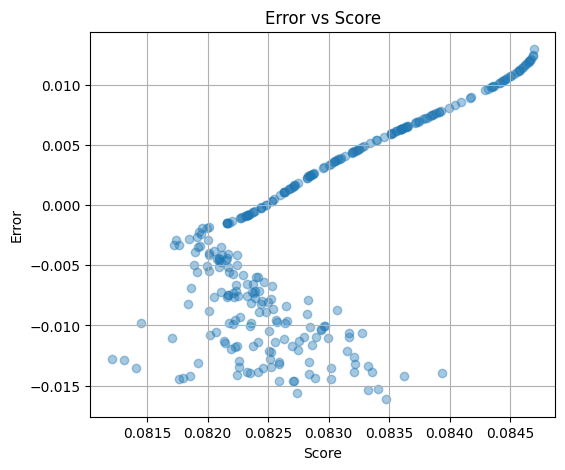

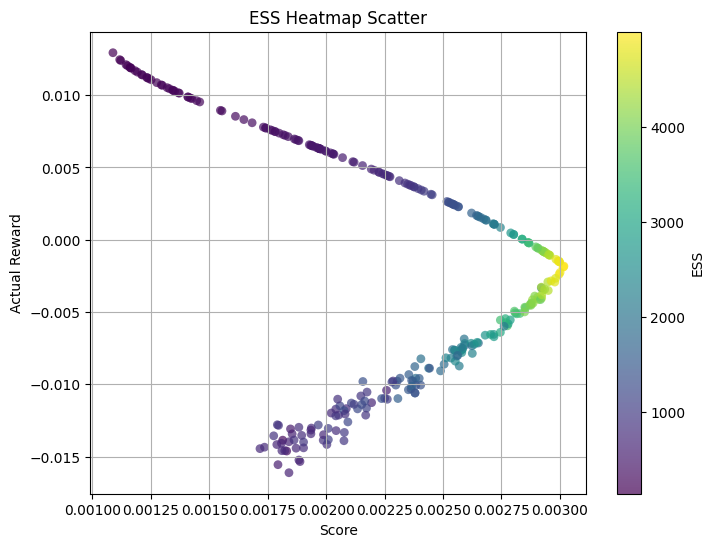

Correlation Metrics: {'pearson_score_actual': np.float64(0.6906156254082417), 'spearman_score_actual': np.float64(0.6281963132923698), 'spearman_est_actual': np.float64(0.27334348159423993)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9966198261405926), 'ndcg_est_actual': np.float64(0.9776632874298734)}
Error Metrics: {'mean_error': np.float64(-0.002161300238215925), 'mae': np.float64(0.00730096510352595), 'rmse': np.float64(0.00841400245238653), 'std_error': np.float64(0.008131679934002217), 'max_error': np.float64(0.012936082266825438), 'min_error': np.float64(-0.016121166498648642)}


In [10]:
compute_statistics_and_plots(jaws)

In [ ]:
compute_statistics_and_plots(df_random)

In [ ]:
compute_statistics_and_plots(df_learning_sim)

In [ ]:
df, _ = random_policy_trainer_trial(
    train_size=15000,
    dataset=train_dataset,
    n_policies=300,
    val_size=10000,
)

In [ ]:
a = False

a * 5.0

In [ ]:
df

In [ ]:
df2 = df_random.copy()
df2['user_attrs_ess'] = df2['sign_exp']
df2['value'] = df2['user_attrs_r_hat']
compute_statistics_and_plots(df2)

In [ ]:
df3 = df2[df2['sign_exp']>0]
df4 = df2[df2['sign_exp']<0]

compute_statistics_and_plots(df3)
compute_statistics_and_plots(df4)

In [ ]:
compute_statistics_and_plots(df2)

In [14]:
df_learning_sim

,value,user_attrs_actual_reward,user_attrs_q_error,user_attrs_r_hat,user_attrs_ess,user_attrs_scores_dict,user_attrs_all_values,ipw,sign_uni,sign_exp
0,0.07977897,0.07583882,0.00149696,0.08271331,"1,137.55410814","{'dr_naive_mean': 0.0827133130390828, 'dr_naiv...","[0.0827133130390828, 8.266546777669733e-06, 7....",0.07278546,0.02662231,0.03883727
1,0.08027213,0.07585596,0.00143832,0.08309154,"1,334.48662602","{'dr_naive_mean': 0.0830915352632233, 'dr_naiv...","[0.0830915352632233, 8.319312044545721e-06, 7....",0.07493230,0.03099870,0.04256680
2,0.08142698,0.08086469,0.00139353,0.08415857,"1,428.25031041","{'dr_naive_mean': 0.08415857252591127, 'dr_nai...","[0.08415857252591127, 8.42021149148545e-06, 8....",0.08138369,-0.06611931,0.08163332
3,0.08191366,0.07940716,0.00127269,0.08440840,505.91267115,"{'dr_naive_mean': 0.08440839824026625, 'dr_nai...","[0.08440839824026625, 8.439673352712308e-06, 8...",0.08670680,0.07214689,0.04830011
4,0.08079110,0.08556277,0.00149162,0.08371498,"1,049.13132263","{'dr_naive_mean': 0.0837149750886736, 'dr_naiv...","[0.0837149750886736, 8.382113959770731e-06, 8....",0.08621616,-0.07006159,-0.10173292
...,...,...,...,...,...,...,...,...,...,...
295,0.08240856,0.07614417,0.00128070,0.08491898,"1,108.72675941","{'dr_naive_mean': 0.08491897787485761, 'dr_nai...","[0.08491897787485761, 8.4973354573797e-06, 7.9...",0.07960439,0.03274132,0.06137456
296,0.07991370,0.08951304,0.00160936,0.08306837,"1,494.07605522","{'dr_naive_mean': 0.08306836895950316, 'dr_nai...","[0.08306836895950316, 8.294852619949812e-06, 8...",0.09095846,0.06245478,0.04325180
297,0.08032490,0.07754512,0.00151154,0.08328782,"2,530.83639887","{'dr_naive_mean': 0.08328782043546011, 'dr_nai...","[0.08328782043546011, 8.332319584949473e-06, 7...",0.07514654,0.03399772,0.04100878
298,0.08178856,0.08384538,0.00137933,0.08449234,"1,097.61704571","{'dr_naive_mean': 0.08449233796352927, 'dr_nai...","[0.08449233796352927, 8.443998262086124e-06, 8...",0.08596098,-0.07188843,0.07783261


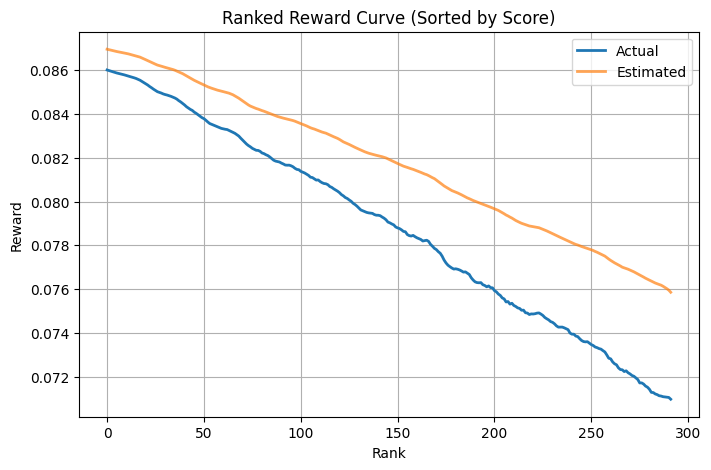

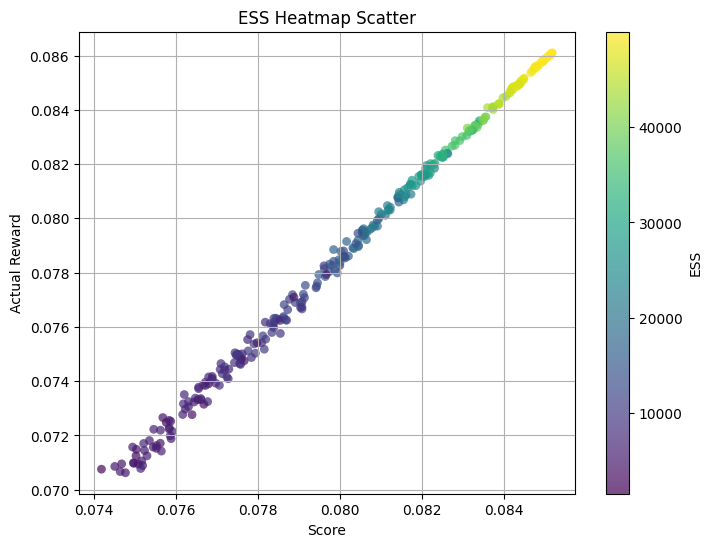

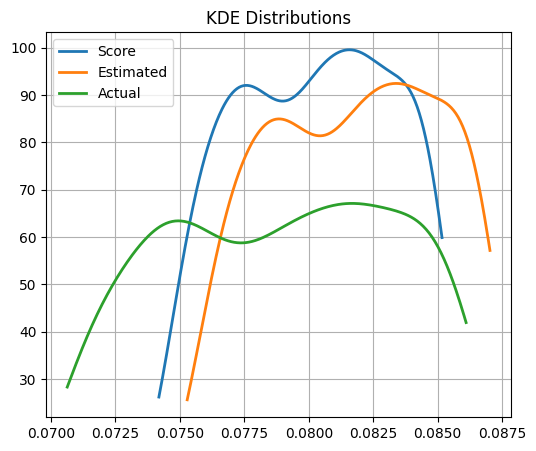

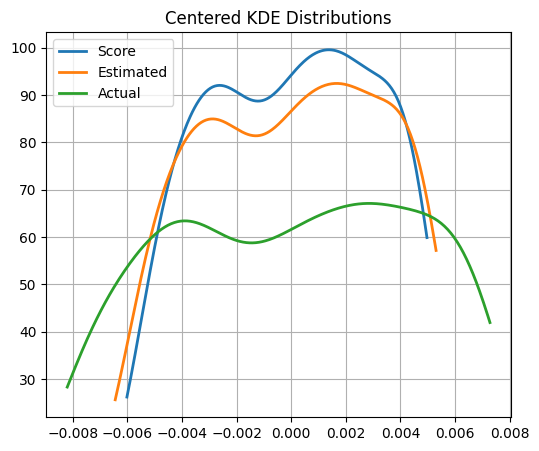

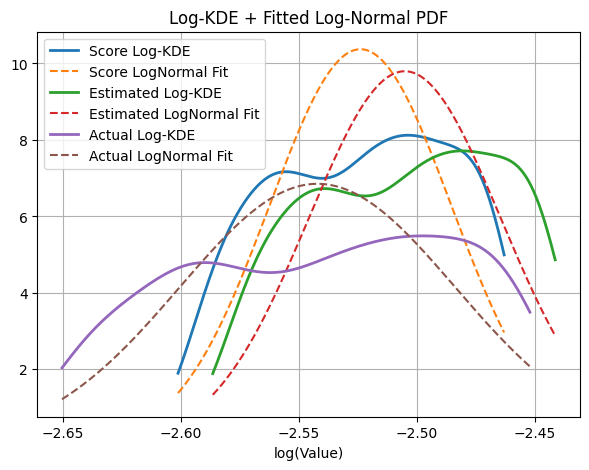

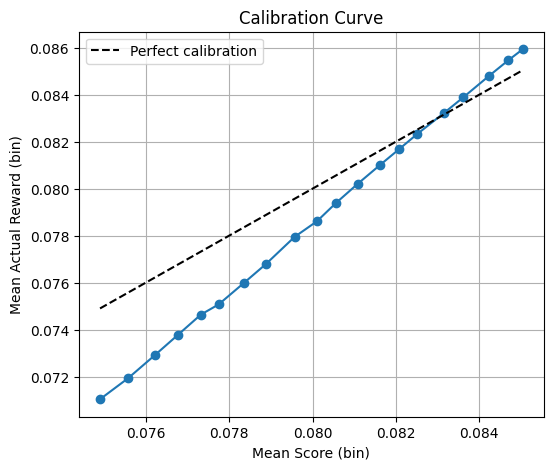

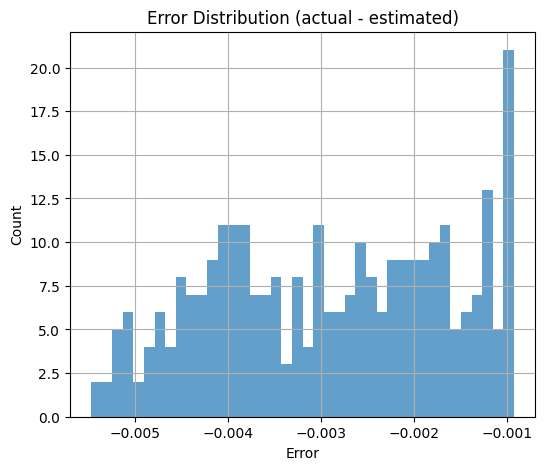

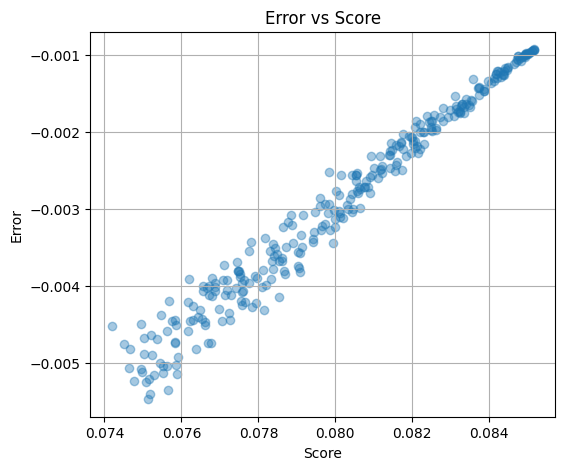

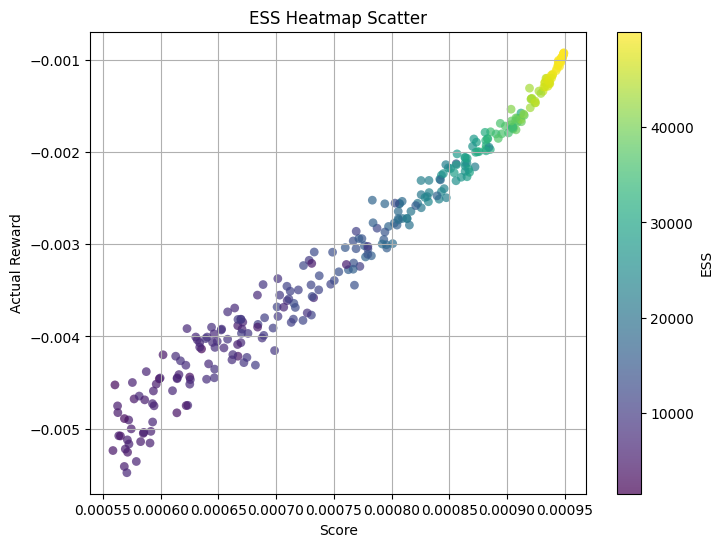

Correlation Metrics: {'pearson_score_actual': np.float64(0.9988715718921837), 'spearman_score_actual': np.float64(0.9989226546961633), 'spearman_est_actual': np.float64(0.9989919887998755)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9999958341923579), 'ndcg_est_actual': np.float64(0.9999961522314367)}
Error Metrics: {'mean_error': np.float64(-0.0028984484934977714), 'mae': np.float64(0.0028984484934977714), 'rmse': np.float64(0.0031609002621955954), 'std_error': np.float64(0.0012610657390035944), 'max_error': np.float64(-0.0009257211511077279), 'min_error': np.float64(-0.005476826862975598)}


In [34]:
compute_statistics_and_plots(rnd)

Plotting calibration for: dr_naive_mean


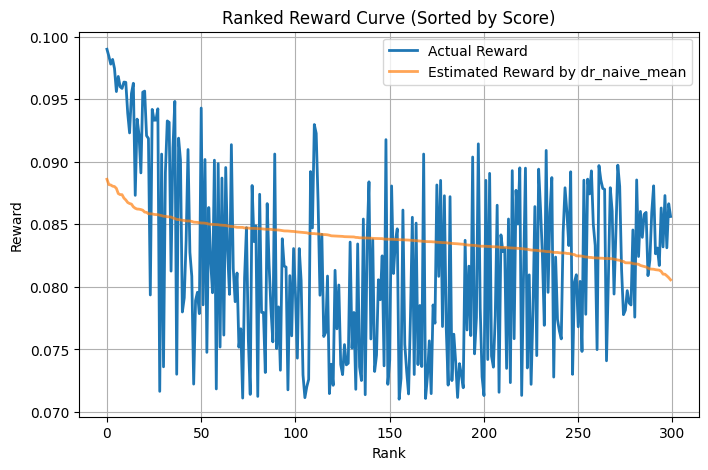

Plotting calibration for: dr_naive_ci_low


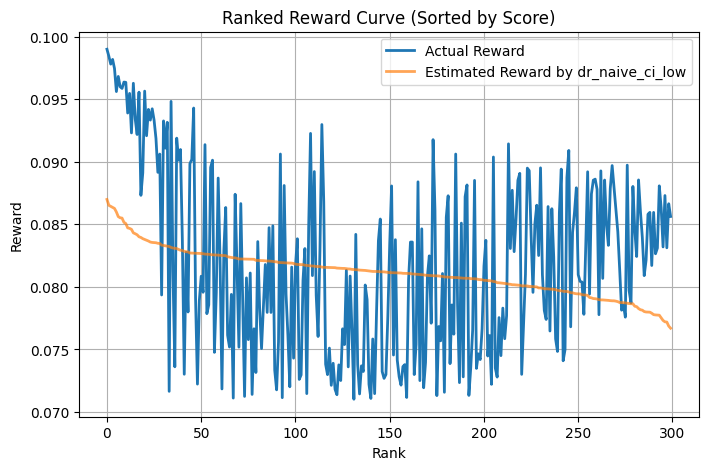

Plotting calibration for: dr_boot_mean


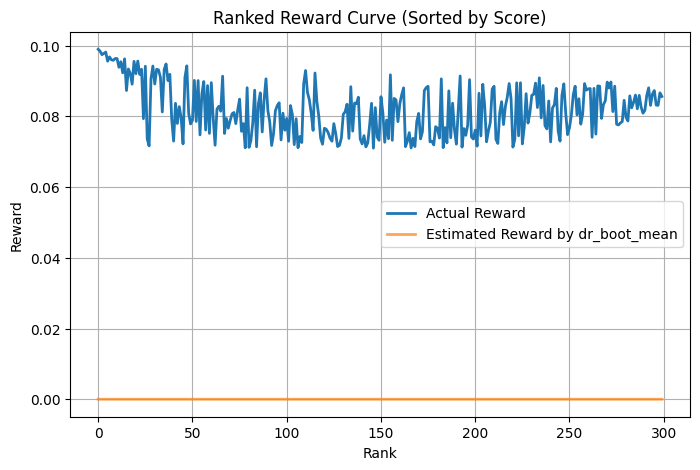

Plotting calibration for: dr_boot_ci_low


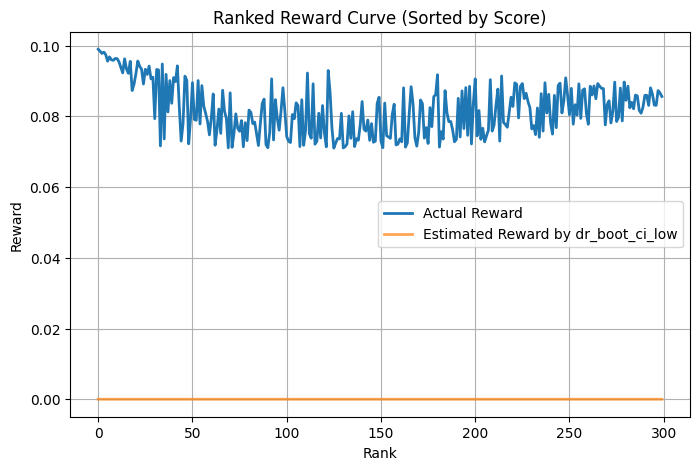

Plotting calibration for: dr_uni_mean


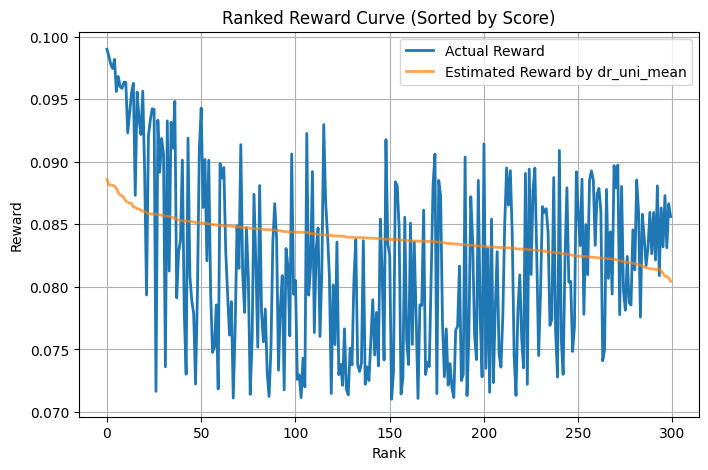

Plotting calibration for: dr_uni_ci_low


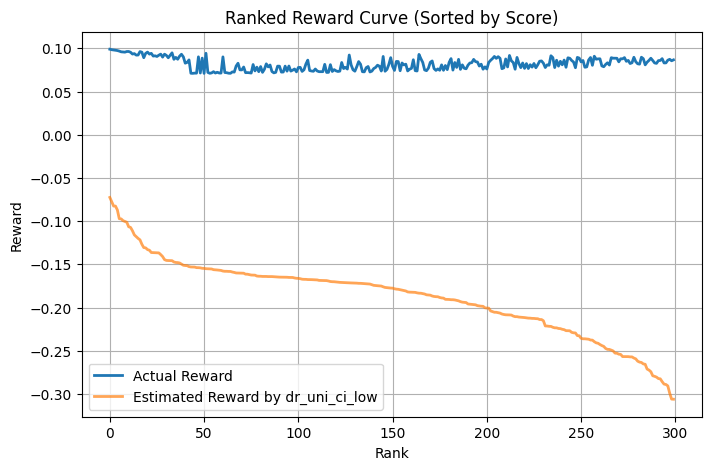

Plotting calibration for: ipw_boot_mean


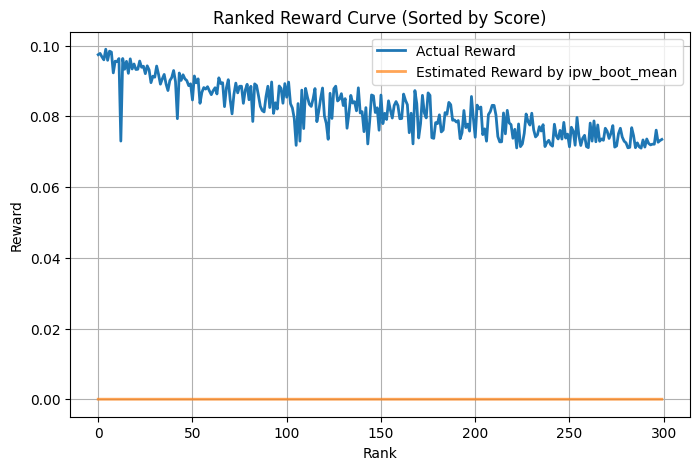

Plotting calibration for: ipw_boot_ci_low


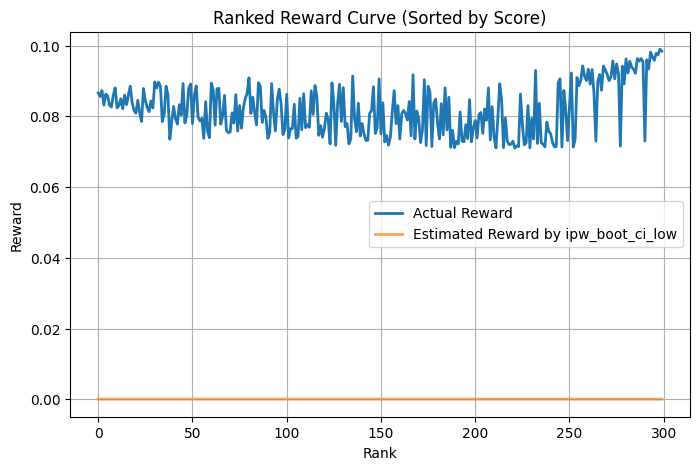

Plotting calibration for: ipw_uni_mean


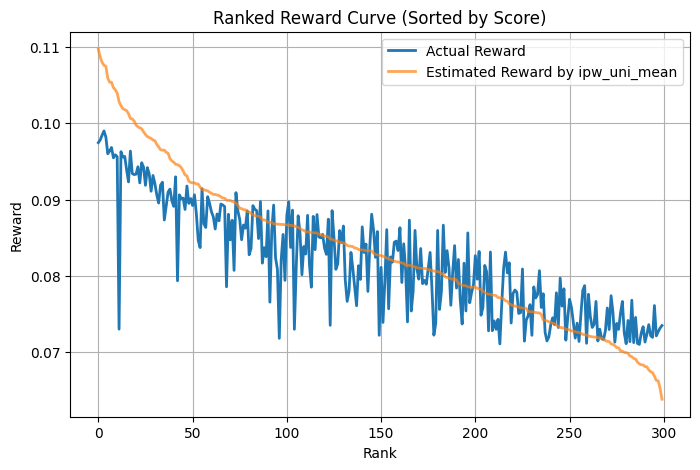

Plotting calibration for: ipw_uni_ci_low


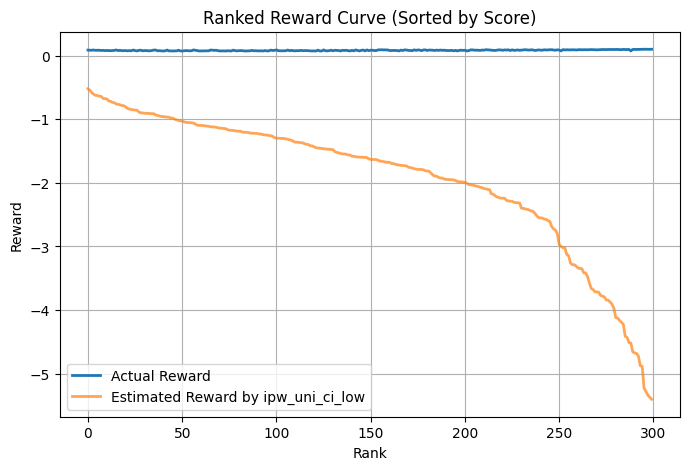

,Spearman-Rank,Kendall-Tau
dr_naive_mean,0.16770897,0.11045708
dr_naive_ci_low,0.11385904,0.06492754
dr_boot_mean,0.16438005,0.10626533
dr_boot_ci_low,0.09867576,0.05186176
dr_uni_mean,0.15939377,0.10394649
dr_uni_ci_low,-0.06193891,-0.10622074
ipw_boot_mean,0.86126601,0.68949833
ipw_boot_ci_low,-0.08920366,-0.02867336
ipw_uni_mean,0.85938999,0.69034560
ipw_uni_ci_low,-0.65979089,-0.48700111


In [11]:
plot_calibration_and_rank_table(
    df_learning_sim,
    cols=cols,
    reward_col="user_attrs_actual_reward"
)

In [ ]:
num_runs = 1
batch_size = 200
num_neighbors = 6
n_trials_for_optuna = 155
# num_rounds_list = [500, 1000, 2000, 10000, 20000]
# num_rounds_list = [500, 1000, 2000]
num_rounds_list = [15000]


# Manually define your best parameters
best_params_to_use = {
    "lr": 0.096,  # Learning rate
    "num_epochs": 5,  # Number of training epochs
    "batch_size": 64,  # Batch size for training
    "num_neighbors": 8,  # Number of neighbors for neighborhood model
    "lr_decay": 0.85  # Learning rate decay factor
}


### 1

$$emb = 0.7 * gt + 0.3 * noise$$
$$lr = 0.005$$
$$n_{epochs} = 1$$
$$BatchSize=50$$

In [ ]:
print("Value of num_rounds_list:", num_rounds_list)

# Run the optimization
df4, study_df = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# # Print best hyperparameters for each training size
# print("\n=== BEST HYPERPARAMETERS BY TRAINING SIZE ===")
# for train_size, params in best_hyperparams_by_size.items():
#     print(f"\nTraining Size: {train_size}")
#     # print(f"Best Reward: {params['reward']:.6f}")
#     print("Parameters:")
#     for param_name, value in params['params'].items():
#         print(f"  {param_name}: {value}")
# print("===========================\n")

# Show the performance metrics
df4[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

In [ ]:
study_df.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{12345}.csv")

compute_statistics_and_plots(study_df)

### Policy with delta function

In [ ]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=10000)

In [ ]:
# Run the optimization
df5, study_df5 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df5.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{10000}.csv")

# Show the performance metrics
df5[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

In [ ]:
study_df5

In [ ]:
compute_statistics_and_plots(study_df5)

In [ ]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=20000)

In [ ]:
# Run the optimization
df6, study_df6 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df6.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{20000}.csv")
# Show the performance metrics
df6[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

In [ ]:
compute_statistics_and_plots(study_df6)

In [ ]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=30000)

In [ ]:
# Run the optimization
df7, study_df7 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df7.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{30000}.csv")
# Show the performance metrics
df7[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

In [ ]:
compute_statistics_and_plots(study_df7)

In [ ]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=40000)

In [ ]:
# Run the optimization
df8, study_df8 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df8.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{40000}.csv")
# Show the performance metrics
df8[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

In [ ]:
compute_statistics_and_plots(study_df8)

In [ ]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=50000)

In [ ]:
# Run the optimization
df9, study_df9 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df9.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{50000}.csv")
# Show the performance metrics
df9[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

In [ ]:
compute_statistics_and_plots(study_df9)

In [ ]:
all_dfs = pd.concat([study_df, study_df5, study_df6, study_df7, study_df8, study_df9], ignore_index=True)
all_dfs = all_dfs[all_dfs['value'] > 0]
# all_dfs['user_attrs_actual_reward'] = all_dfs['user_attrs_actual_reward'].apply(lambda x: x[0])

In [ ]:
all_dfs.head(5)

In [ ]:
from plots_and_stats import compute_statistics_and_plots
import pandas as pd

In [ ]:
all_dfs.to_csv(f"trial_dfs/regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv", index=False)

In [ ]:
all_dfs = pd.read_csv(f"regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv")

In [ ]:
compute_statistics_and_plots(all_dfs)